In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import h5py

import agama

# import utilities as ut
# import gizmo_analysis as gizmo


%matplotlib inline

# Set unit of Agama to (mass, length, velocity) = (1 Msun, 1 kpc, 1 km/s)
agama.setUnits(mass=1, length=1, velocity=1)

plt.style.use('seaborn-colorblind')
mpl.rcParams.update({
    'font.size': 18,
    'figure.figsize': (8, 6),
    'figure.facecolor': 'w',
    'axes.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

In [2]:
# Read in DM potential and bar potential
pxr_DM = agama.Potential(file=
                         "/ocean/projects/phy210068p/hsu1/Fire_simulation/m12i_res7100/600.dark.axi_4.coef_mul_DR")
pxr_bar = agama.Potential(file=
                          "/ocean/projects/phy210068p/hsu1/Fire_simulation/m12i_res7100/600.bar.axi_4.coef_cylsp_DR")

# Combine bar and DM potential
potential = agama.Potential(pxr_DM, pxr_bar)

In [3]:
# Read in accretion history for simulation action angle calculations
# csv = pd.read_csv('/ocean/projects/phy210068p/hsu1/data/Ananke/stars_accretion_history_m12i_res7100_v2.csv')
# acc_id = csv.id_stars
# with h5py.File(path, 'r') as f:
#     ananke_id = f['parentid'][:]
# accretion_id = np.isin(ananke_id, acc_id)
# acc_mask = (accretion_id==1)

In [23]:
# Load in galactocentric coordinates
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced_feh.hdf5'
with h5py.File(path, 'r') as f:
    x_gal = f['x_gal'][:]
    y_gal = f['y_gal'][:]
    z_gal = f['z_gal'][:]
    vx_gal = f['vx_gal'][:]
    vy_gal = f['vy_gal'][:]
    vz_gal = f['vz_gal'][:]
    # ra = f['ra'][:]
    # dec = f['dec'][:]
    # parallax = f['parallax'][:]
    # pmra = f['pmra'][:]
    # pmdec = f['pmdec'][:]
    # rv = f['radial_velocity'][:]

# Store a copy of galactocentric coordinates
store_x_gal = x_gal

In [26]:
# Integrate and plot the orbit for 10 Billion years
posvel_accreted = np.stack([
    x_gal, y_gal, z_gal, vx_gal, vy_gal, vz_gal
], 1)

In [27]:
# Create an action finder from the potential to calculate the action
action_finder = agama.ActionFinder(potential)
Jr, Jz, Jphi = action_finder(posvel_accreted).T

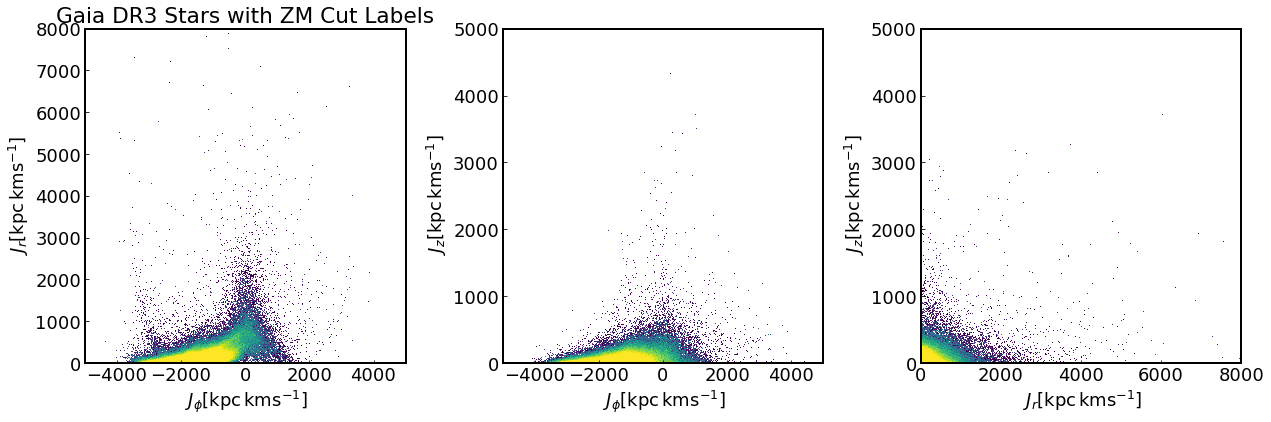

In [29]:
# 2D histogram of actions
def plot_action(Jr, Jz, Jphi, hist_range, bins=1000, norm=None):
    ''' Plot the 2d distribution of the actions'''
    
    if norm is None:
        norm = mpl.colors.LogNorm(vmin=1, vmax=100)    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].hist2d(
        Jphi, Jr, bins=(bins, bins), range=(hist_range[2], hist_range[0]), norm=norm)
    axes[1].hist2d(
        Jphi, Jz, bins=(bins, bins), range=(hist_range[2], hist_range[1]), norm=norm)
    axes[2].hist2d(
        Jr, Jz, bins=(bins, bins), range=(hist_range[0], hist_range[1]), norm=norm)

    axes[0].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_xlabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[0].set_ylabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    fig.tight_layout()
    axes[0].set_title('Gaia DR3 Stars with ZM Cut Labels')
    #fig.colorbar(axes[2])
    
    return fig, axes

hist_range = ((0, 8000), (0, 5000), (-5000, 5000))
bins = 1000
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
fig, axes = plot_action(Jr, Jz, Jphi, hist_range, bins, norm)

In [16]:
new_Jr = np.empty(len(store_x_gal))
new_Jr[:] = np.nan
new_Jz = np.empty(len(store_x_gal))
new_Jz[:] = np.nan
new_Jphi = np.empty(len(store_x_gal))
new_Jphi[:] = np.nan


In [31]:
with h5py.File(path, 'a') as f:
#     del f['Jr']
#     del f['Jz']
#     del f['Jphi']
    f.create_dataset('Jr', data=Jr)
    f.create_dataset('Jz', data=Jz)
    f.create_dataset('Jphi', data=Jphi)

# Check the keys of the file

f = h5py.File(path, 'r')
f.keys()